In [3]:
library(ggplot2)      # Core plotting functionality
library(ggalluvial)   # Alluvial plot creation
library(dplyr)        # Data manipulation
library(RColorBrewer) # Color palette generation
library(gridExtra)    # Grid-based plot arrangements
library(rlang)        # Programming tools for R
library(tidyr)        # Data reshaping (pivot functions)
library(patchwork)    # Combining multiple plots into panels

df <- read.csv('/home/workspace/pbmc_flow/data/Cell Engine results_PBMC flu new format.csv')  # Load cleaned PBMC data


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




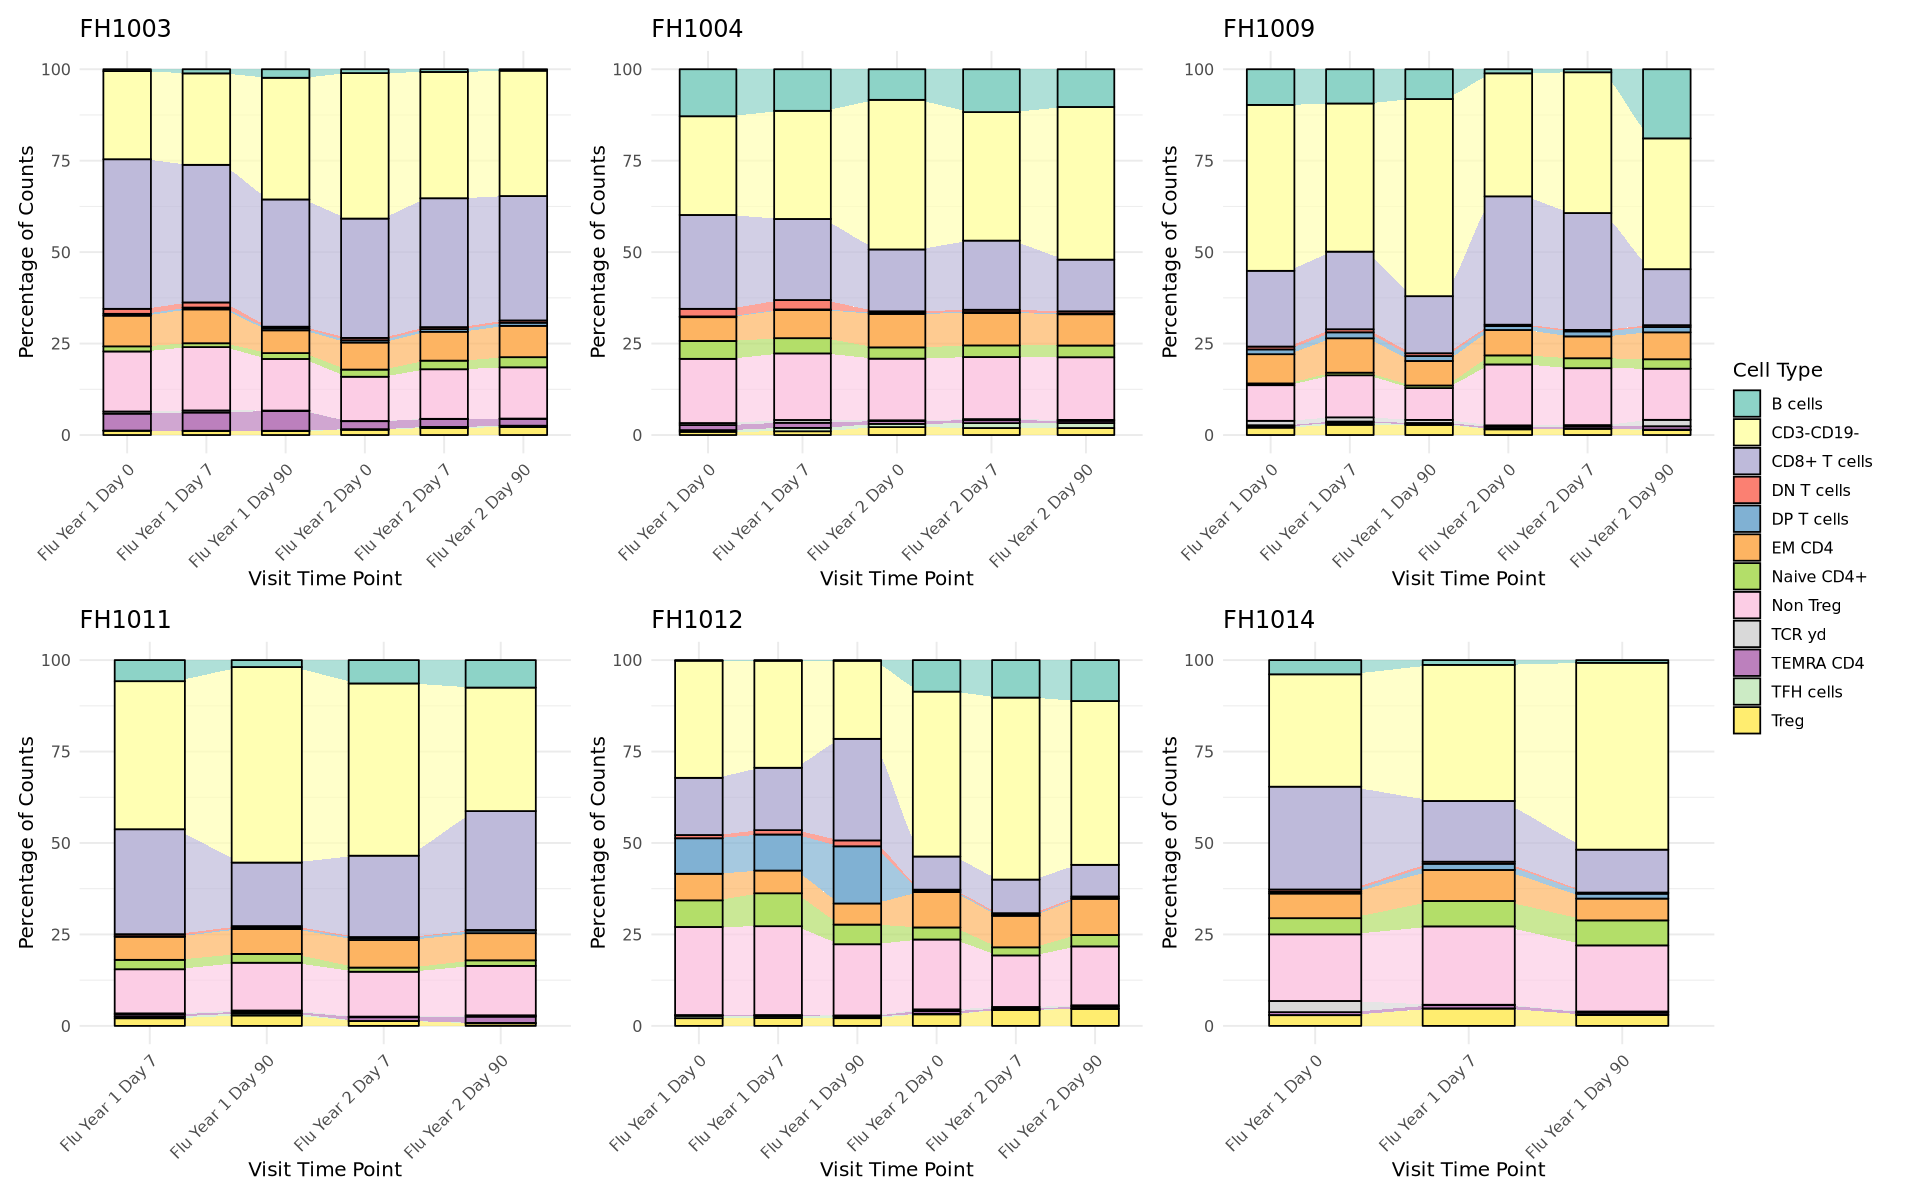

In [3]:
options(repr.plot.width = 16, repr.plot.height = 10)  # Set large plot dimensions for multi-panel display

library(ggplot2)
library(ggalluvial)
library(RColorBrewer)
library(patchwork)

# Load data
df <- read.csv('/home/workspace/pbmc_flow/data/Cell Engine results_PBMC flu new format.csv')

# Get unique subjects
subjects <- unique(df[['Subject']])
subjects <- subjects[subjects != 'FH1016']

# Define timepoint order
timepoints <- c(
    'Flu Year 1 Day 0',
    'Flu Year 1 Day 7',
    'Flu Year 1 Day 90',
    'Flu Year 2 Day 0',
    'Flu Year 2 Day 7',
    'Flu Year 2 Day 90'
)

# Create plots for each subject
plots <- lapply(seq_along(subjects), function(x) {
    # Filter data for current subject
    temp <- df[df[['Subject']] == subjects[[x]],]
    
    # Check available visits for this subject
    available_visits <- unique(temp$Visit)
    
    # Replace Day 0 with Stand-Alone if Day 0 is missing but Stand-Alone is available
    if (!'Flu Year 1 Day 0' %in% available_visits & 'Flu Year 1 Stand-Alone' %in% available_visits) {
        temp$Visit[temp$Visit == 'Flu Year 1 Stand-Alone'] <- 'Flu Year 1 Day 0'
    }
    
    if (!'Flu Year 2 Day 0' %in% available_visits & 'Flu Year 2 Stand-Alone' %in% available_visits) {
        temp$Visit[temp$Visit == 'Flu Year 2 Stand-Alone'] <- 'Flu Year 2 Day 0'
    }
    
    # Filter to only include the timepoints we want
    temp <- temp[temp$Visit %in% timepoints, ]
    
    # FIXED: Calculate percentage within each visit using base R ave() function
    temp$percentage <- ave(temp$eventCount, temp$Visit, FUN = function(x) (x / sum(x)) * 100)
    
    # Set factor levels for visits
    temp$Visit <- factor(temp$Visit, levels = timepoints)
    
    # Remove any visits that have no data after filtering
    temp <- temp[!is.na(temp$Visit), ]
    
    # Set up colors
    n_cell_types <- length(unique(temp$population))
    if (n_cell_types <= 12) {
        colors <- brewer.pal(max(3, n_cell_types), "Set3")
    } else {
        colors <- c(brewer.pal(12, "Paired"), brewer.pal(8, "Set1"))[1:n_cell_types]
    }
    
    # Create the plot
    p <- ggplot(temp, aes(x = Visit,
                         stratum = population, 
                         alluvium = population, 
                         y = percentage,
                         fill = population)) +
        geom_alluvium(width = 0.1, alpha = 0.7) +
        geom_stratum(width = 0.6) +
        scale_fill_manual(values = colors) +
        theme_minimal(base_size = 12) +
        theme(
            legend.position = "right", 
            legend.margin = margin(0, 20, 0, 0),
            axis.text.x = element_text(angle = 45, hjust = 1)
        ) +
        labs(x = "Visit Time Point",
             y = "Percentage of Counts",
             title = subjects[[x]]) +
        guides(fill = guide_legend(title = "Cell Type"))
    
    return(p)
})

patchwork_plots <- lapply(seq_along(plots), function(i) {
  if (i == 1) {
    plots[[i]]
  } else {
    plots[[i]] + theme(legend.position = "none")
  }
})

final_plot <- wrap_plots(patchwork_plots, ncol = 3) +
  plot_layout(guides = "collect")

print(final_plot)